# Vehicle time response reliability on vehicle automation: Evidence from experimental driving modes in platooning conditions

## Finding Response Time 

The following procedures consist in importing the available datasets and compute the response time of vehicles in a platoon mode. For that the methodology is as follows: 

1. Consider a profile of speed for a leader `leader_GPS_CARMA_speed` or a follower, in this case follower 1 denoted as `follower1_GPS_CARMA_speed`. 
2. Missing samples as well as negative speeds are removed from the signals. 
2. A moving average will be applied with a specific window `h=10` (~1s. according to sampling frequency) to filter out noise. 
3. The standard deviation of a sliding window of length `h=10` (~1s. according to sampling frequency) will compute variation on the speed in time. 
4. The derivative of the speed standard deviation is computed and afterwards the standard deviation of this signal is computed. This will be used as a *threshold* to determine variations on the speed.
5. In order to detect variation for a determined sample of speed a sliding window examines a future horizon of length `FORWARD_WINDOW`. In case the 80% percentile of the absolute standard deviation is above the *threshold*, then the sample is stored as a changing sample.  
6. One changing samples are retained, the changing sample is marked as `True` in a boolean time series. 
7. An xor logic is used to determine changes from 0 to 1 or activations of the samples. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import glob 
from functools import partial 
import operator

### Data loading

Files are loaded from `data/raw`

In [2]:
# Catch al files 
files2load = glob.glob("data/raw/*.csv")
print(files2load)

# Load files 
lst_datas = []
for file in files2load:
    lst_datas.append(pd.read_csv(file, sep = ',', decimal = '.'))

# 
keys = [x.split('.')[0].split('/')[-1] for x in files2load] 
dfTotal = pd.concat(lst_datas,keys=keys , names = ['Experiment'])

# Compute spacing between vehicles and their leaders. 

for i in (1,2,3,4):
    if i==1:
        dfTotal[f'distToLeader_f{i}'] = dfTotal[f'follower{i}_radar1']
    else:
        dfTotal[f'distToLeader_f{i}'] = dfTotal[f'follower{i-1}_radar1']+dfTotal[f'follower{i}_radar1']
    

['data/raw/data5.csv', 'data/raw/data6.csv', 'data/raw/data9.csv', 'data/raw/data12.csv', 'data/raw/data13.csv', 'data/raw/data10.csv']


### Cleaning Data 

Eliminating `NaN` values and limitting speeds in between 0~50

In [3]:
# Clean data 
lst_datas_flt = [] 

for i in range(5):
    if i == 0: 
        lead_clean = dfTotal[~dfTotal['leader_GPS_CARMA_speed'].isna()]
        follower_clean = lead_clean.copy()
        lst_datas_flt.append(lead_clean)
    else: 
        follower_clean = follower_clean[~follower_clean[f'follower{i}_GPS_CARMA_speed'].isna()]
        lst_datas_flt.append(follower_clean)
    
dfFilter = pd.concat(lst_datas_flt).drop_duplicates()

# Cliping values between 0 ~ 50 (for min speed) 

dfCliped=dfFilter.copy()
dfCliped['leader_GPS_CARMA_speed'] = dfCliped['leader_GPS_CARMA_speed'].clip(0,50)

# Sorting values
dfSorted = dfCliped.reset_index().sort_values(by=['Heure','Time']).set_index(['Experiment','level_1'])

### Average Speed and Variation 

Example for the leader case

In [4]:
def plot_exps(df,col):
    f,ax = plt.subplots(1,len(keys), figsize = (30,6))
    f.suptitle(col)
    for x, a in zip(df.groupby('Experiment'),ax.flatten()):
        x[1].plot(x='Time',y=col,ax=a,title = f'Exp. {x[0]}', grid =True);
        a.get_legend().remove()
    return f,ax

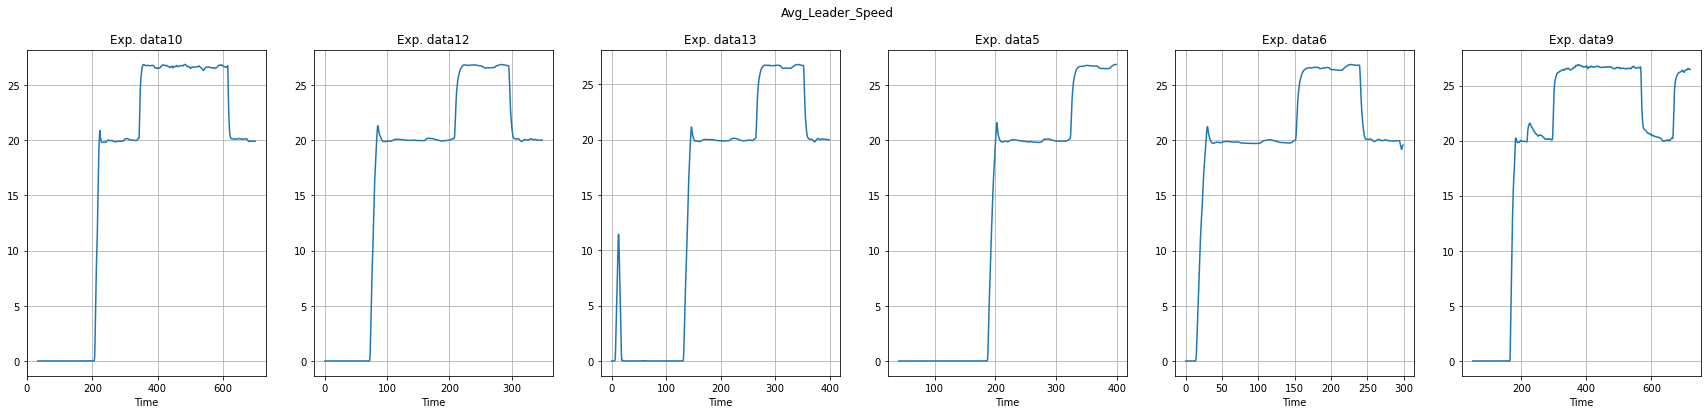

In [5]:
# Moving average   
lst_ma_spd = [] 
lst_sd_spd = [] 
h = 10 # Window size

# Forward indexer (to account for k+h instead of classic k-h)
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=h)

# Find average speed 
for key in keys:
    lst_ma_spd.append(dfSorted.loc[(key,slice(None)),'leader_GPS_CARMA_speed'].rolling(window=indexer).mean())
dfSorted['Avg_Leader_Speed'] = pd.concat(lst_ma_spd)

# Find standard deviation From Avg. Speed
for key in keys:
    lst_sd_spd.append(dfSorted.loc[(key,slice(None)),'Avg_Leader_Speed'].rolling(window=indexer).std())
dfSorted['Std_Leader_Speed'] = pd.concat(lst_sd_spd)

# Find derivative of Std. 
lst_dsd_spd = []
for key in keys: 
    lst_dsd_spd.append(dfSorted.loc[(key,slice(None)),'Std_Leader_Speed'].diff())
dfSorted['Diff_Std_Leader_Speed'] = pd.concat(lst_dsd_spd)
dfSorted['Abs_Diff_Std_Leader_Speed'] = abs(dfSorted['Diff_Std_Leader_Speed'])

# Plot info
plot_exps(dfSorted, 'Avg_Leader_Speed');
# plot_exps(dfSorted, 'Std_Leader_Speed');

### Threshold of variation 

Determining the threshold of speed variation 

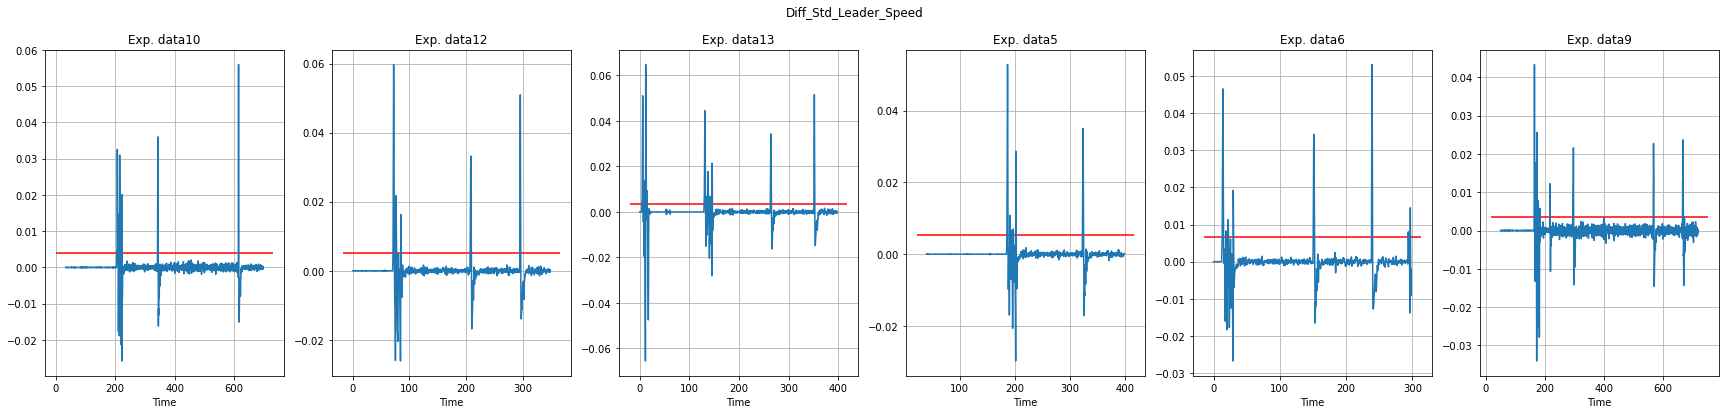

In [6]:
dct_sd_sdspd = {}
for key in keys:
    dct_sd_sdspd[key]=dfSorted.loc[(key,slice(None)),'Std_Leader_Speed'].diff().std()

f,a = plot_exps(dfSorted, 'Diff_Std_Leader_Speed')
for dctv, ax in zip(dct_sd_sdspd.items(),a.flatten()):
    key, val = dctv
    ax.hlines(val,*ax.get_xlim(),color='r')

### Changing values 

This is the detection of changing values of speed based on the variation of speed. 

Processing: data5
Processing: data6
Processing: data9
Processing: data12
Processing: data13
Processing: data10


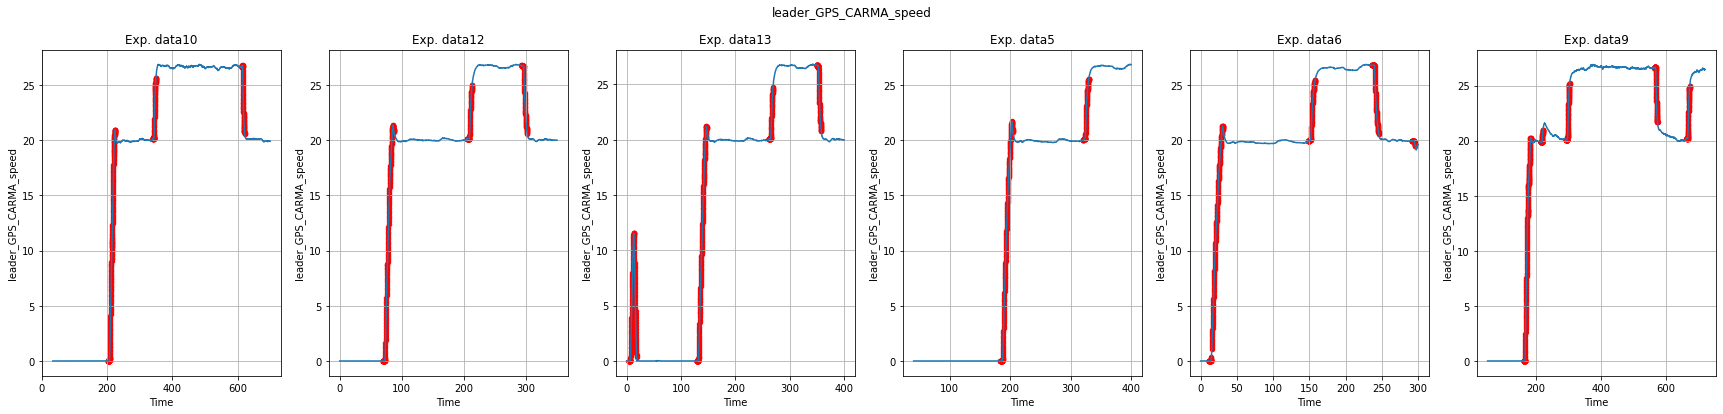

In [7]:
FORWARD_WINDOW = 20
indexerFuture = pd.api.indexers.FixedForwardWindowIndexer(window_size=FORWARD_WINDOW)

FACTOR_SPEED_CHG = 95
# perc = partial(lambda x,y: np.percentile(y,x),FACTOR_SPEED_CHG)

l_prc80 = [] 
l_select = [] 
for key in keys: 
    print(f"Processing: {key}")
    
    # Compute future window percentile over Abs(Diff(std)) -> 
    l_prc80.append(dfSorted.loc[(key,slice(None)),"Abs_Diff_Std_Leader_Speed"].rolling(window=indexerFuture).apply(np.percentile, args = (FACTOR_SPEED_CHG,)).dropna())

    # Select appropiate ones: Mark as true samples which 80 perc > 
    l_select.append(l_prc80[-1]>dct_sd_sdspd[key])
    
dfSorted['Change'] = pd.concat(l_select)
dfSorted['Change'].fillna(False,inplace=True)

# Plotting changing values 
f,a = plot_exps(dfSorted, 'leader_GPS_CARMA_speed')
for dfitems, ax in zip(dfSorted.groupby('Experiment'),a.flatten()):
    key, df = dfitems
    df[df.Change].plot(x='Time',y='leader_GPS_CARMA_speed', ax = ax, kind='scatter', color = 'r', grid = True)

### Determining begining of the transitions

The following is an algorithm to determine begining of the transitions. All candidate samples marked for change are converted to boolean values. A logic inspired by the `XOR` behavior `lambda x: not x[0] and x[1]` determines transitions in the boolean series. Transitions allow for detection of detection of speed transitions. 

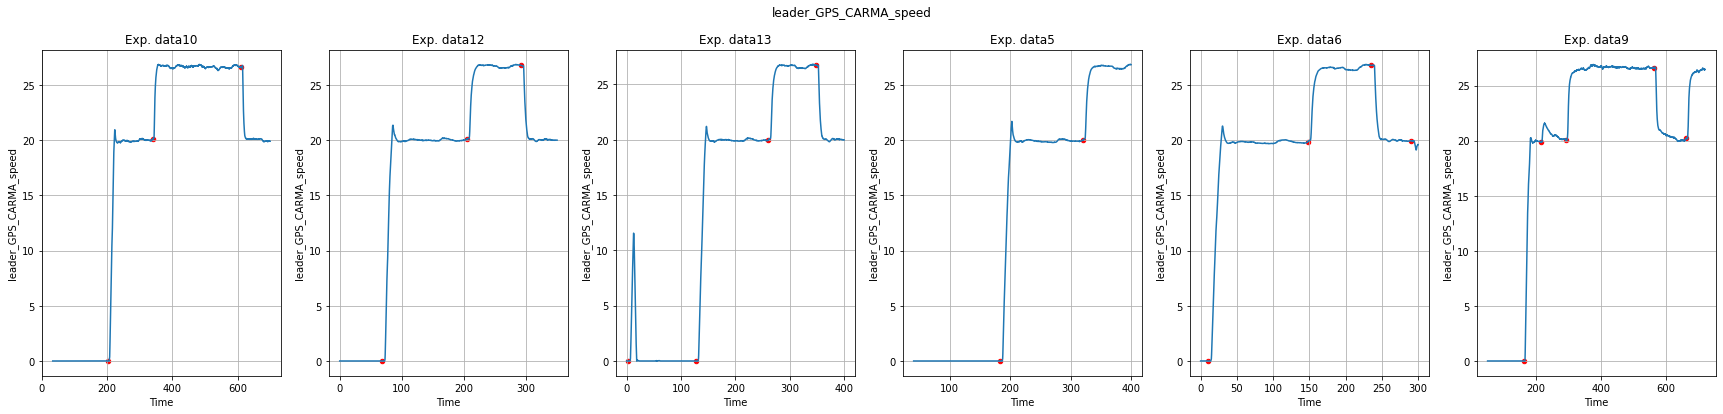

In [8]:
# Get first occurences 

FORWARD_WINDOW = 10
indexerFuture = pd.api.indexers.FixedForwardWindowIndexer(window_size=FORWARD_WINDOW)

# Computing Percentage of Samples ahead
l_detection = []
l_ratio = []
for key in keys:
    
    # Find % of Samples 
    total = dfSorted.loc[(key,slice(None)),'Change'].rolling(window=indexerFuture).sum()
    count = dfSorted.loc[(key,slice(None)),'Change'].rolling(window=indexerFuture).count()
    ratio = total.divide(count)

    bool_ratio= ratio.astype(bool)
    bool_detection = bool_ratio.rolling(2).apply(lambda x: not x[0] and x[1]).dropna() # Peak detections via XoR
    l_ratio.append(ratio)
    
    # We delete the last sample this is the change produced by NaN values. 
    l_detection.append(bool_detection[:-FORWARD_WINDOW]) 

dfSorted['Detections'] = pd.concat(l_detection)
dfDetections = dfSorted[dfSorted['Detections']>0][['Time','leader_GPS_CARMA_speed']]

# Plot information 
f,a = plot_exps(dfSorted, 'leader_GPS_CARMA_speed')
for dfitems, ax in zip(dfDetections.groupby('Experiment'),a.flatten()):
    key, df = dfitems
    df.plot(x='Time',y='leader_GPS_CARMA_speed', ax = ax, kind='scatter', color = 'r', grid = True)

In [9]:
dfDetections

Time  leader_GPS_CARMA_speed
Experiment level_1                               
data12     685       68.5                   0.000
           2043     204.3                  20.096
           2917     291.7                  26.780
data13     26         2.6                   0.000
           1277     127.7                   0.001
           2607     260.7                  19.985
           3484     348.4                  26.733
data5      1829     182.9                   0.001
           3198     319.8                  19.992
data6      103       10.3                   0.000
           1476     147.6                  19.867
           2355     235.5                  26.785
           2906     290.6                  19.949
data9      1610     161.0                   0.000
           2136     213.6                  19.916
           2916     291.6                  20.056
           5636     563.4                  26.608
           6624     662.4                  20.218
data10     2022     202.2                   0.000
           3393     339.3                  20.085
           6113     611.3                  26.593

# Processing data for the followers

The same logic is applied for followers:

In [10]:
def plot_followers(df,cols):
    f,ax = plt.subplots(1,len(keys), figsize = (30,6))
    f.suptitle('')
    for x, a in zip(df.groupby('Experiment'),ax.flatten()):
        [x[1].plot(x='Time',y=col,ax=a,title = f'Exp. {x[0]}', grid =True) for col in cols]
        a.get_legend().remove()
    lines, labels = f.axes[-1].get_legend_handles_labels()
    ax[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)
    return f,ax

Cleaning data and observing speeds behaviors

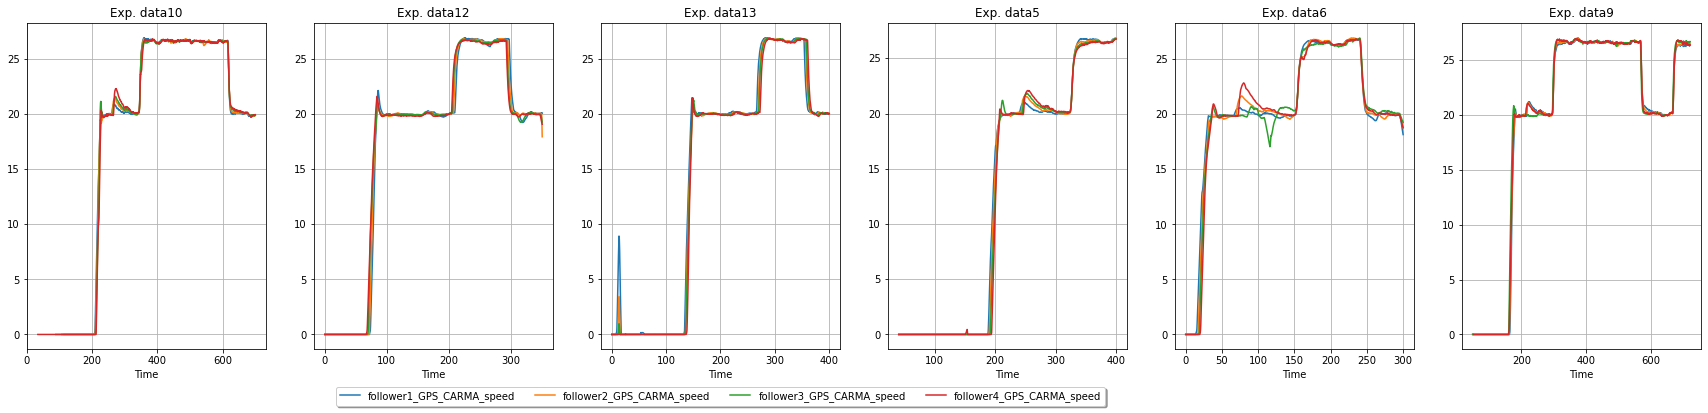

In [11]:
followers = [f'follower{i}_GPS_CARMA_speed' for i in range(1,5)]

# Cleaning negative values 
dfClipedF=dfSorted.copy()
dfClipedF[followers] = dfCliped[followers].clip(0,50)

plot_followers(dfClipedF,followers);

### Detection of transitions. 

The procedure here is sumarized in a function that will perform the steps same as for the leader. 

In [12]:
def detect_column(newdf):
    """
        Reives a DataFrame with 2 columns ['Time', 'Follower_Speed']
    """
    
    # Moving average 
    lst_ma_spd = [] 
    lst_sd_spd = [] 
    h = 10 # Window size
    
    # Forward indexer (to account for k+h instead of classic k-h)
    indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=h)
    
    col = newdf.columns[-1]
    vid = newdf.columns[1].split('_')[0]

    # Names
    n_avg_spd = f'{vid}_Avg_Speed'
    n_std_spd = f'{vid}_Std_Speed'
    n_diff_sd = f'{vid}_Diff_Std_Speed'
    n_abs_diff = f'{vid}_Abs_Diff_Std_Leader_Speed'
    n_changes = f'{vid}_Change'
    n_detection = f'{vid}_Detection'
    
    
    # Find average speed 
    for key in keys:
        lst_ma_spd.append(newdf.loc[(key,slice(None)),col].rolling(window=indexer).mean())
    

    newdf[n_avg_spd] = pd.concat(lst_ma_spd)

    # Find standard deviation From Avg. Speed
    for key in keys:
        lst_sd_spd.append(newdf.loc[(key,slice(None)), n_avg_spd].rolling(window=indexer).std())
    newdf[n_std_spd] = pd.concat(lst_sd_spd)

    # Find derivative of Std. 
    lst_dsd_spd = []
    for key in keys: 
        lst_dsd_spd.append(newdf.loc[(key,slice(None)),n_std_spd].diff())
    newdf[n_diff_sd] = pd.concat(lst_dsd_spd)
    newdf[n_abs_diff] = abs(newdf[n_diff_sd])
    
    
    FORWARD_WINDOW = 20
    indexerFuture = pd.api.indexers.FixedForwardWindowIndexer(window_size=FORWARD_WINDOW)

    FACTOR_SPEED_CHG = 95

    l_prc80 = [] 
    l_select = [] 
    for key in keys: 
        print(f"Processing: {key}")

        # Compute future window percentile over Abs(Diff(std)) -> 
        l_prc80.append(newdf.loc[(key,slice(None)),n_abs_diff].rolling(window=indexerFuture).apply(np.percentile, args = (FACTOR_SPEED_CHG,)).dropna())

        # Select appropiate ones: Mark as true samples which 80 perc > 
        l_select.append(l_prc80[-1]>dct_sd_sdspd[key])

    newdf[n_changes] = pd.concat(l_select)
    newdf[n_changes].fillna(False,inplace=True)

    # Get first occurences 
    FORWARD_WINDOW = 10
    indexerFuture = pd.api.indexers.FixedForwardWindowIndexer(window_size=FORWARD_WINDOW)

    # Computing Percentage of Samples ahead
    l_detection = []
    l_ratio = []
    for key in keys:

        # Find % of Samples 
        total = newdf.loc[(key,slice(None)),n_changes].rolling(window=indexerFuture).sum()
        count = newdf.loc[(key,slice(None)),n_changes].rolling(window=indexerFuture).count()
        ratio = total.divide(count)

        bool_ratio= ratio.astype(bool)
        bool_detection = bool_ratio.rolling(2).apply(lambda x: not x[0] and x[1]).dropna() # Peak detections via XoR
        l_ratio.append(ratio)

        # We delete the last sample this is the change produced by NaN values. 
        l_detection.append(bool_detection[:-FORWARD_WINDOW]) 

    newdf[n_detection] = pd.concat(l_detection)
    dfDetections = newdf[newdf[n_detection]>0]
    return dfDetections

Executing detection 

In [13]:
detections_followers = []
for col in dfClipedF[followers]:
    print(f'Treating: {col}')
    detections_followers.append(detect_column(dfClipedF[['Time',col]].copy()))

Treating: follower1_GPS_CARMA_speed
Processing: data5
Processing: data6
Processing: data9
Processing: data12
Processing: data13
Processing: data10
Treating: follower2_GPS_CARMA_speed
Processing: data5
Processing: data6
Processing: data9
Processing: data12
Processing: data13
Processing: data10
Treating: follower3_GPS_CARMA_speed
Processing: data5
Processing: data6
Processing: data9
Processing: data12
Processing: data13
Processing: data10
Treating: follower4_GPS_CARMA_speed
Processing: data5
Processing: data6
Processing: data9
Processing: data12
Processing: data13
Processing: data10


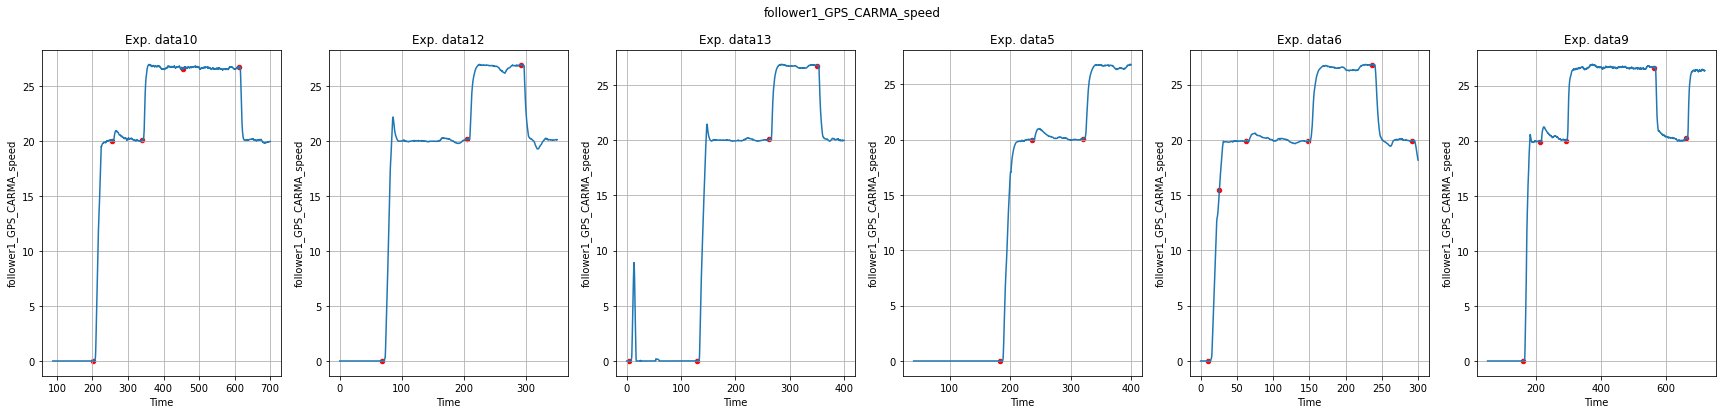

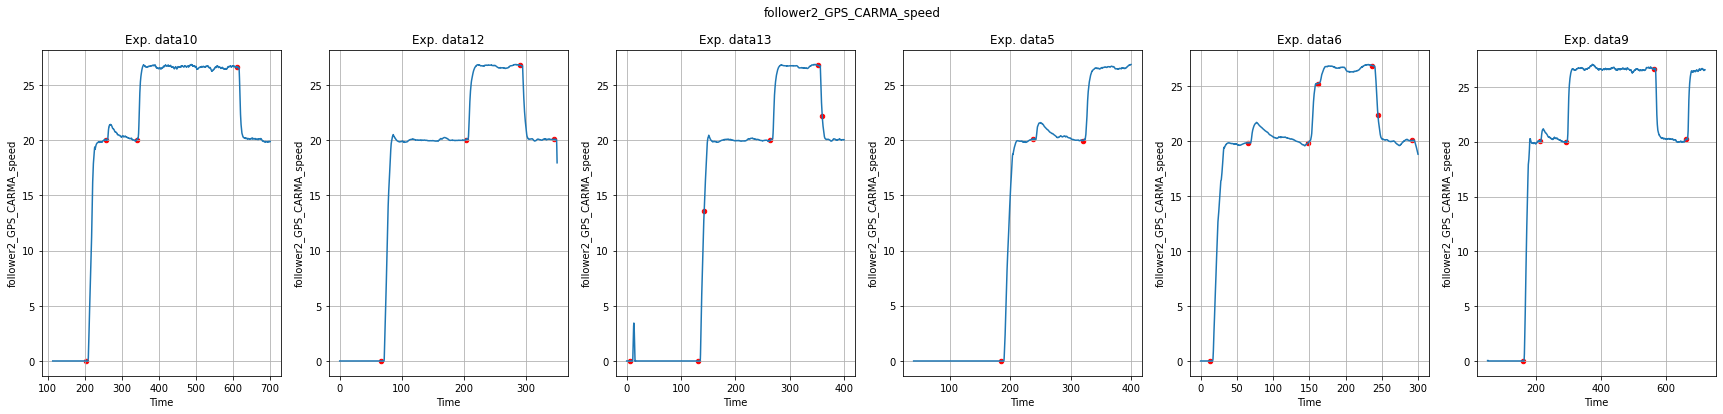

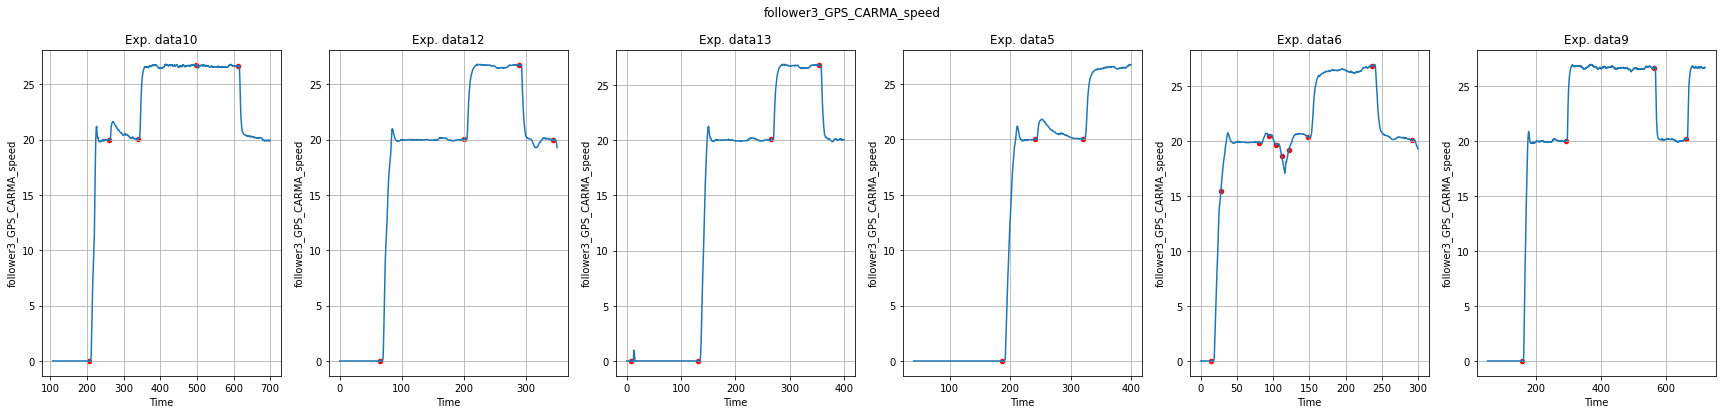

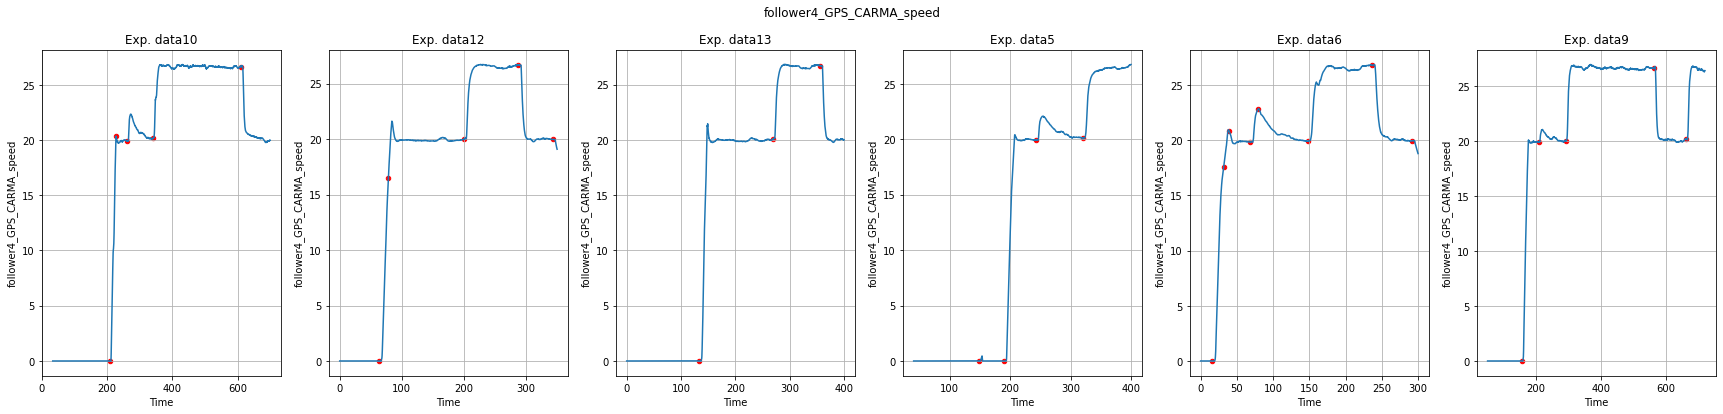

In [14]:
for follower,detection_follower in zip(followers,detections_followers): 
    f,a = plot_exps(dfClipedF, follower)

    for dfitems, ax in zip(detection_follower.groupby('Experiment'),a.flatten()):
        key, df = dfitems
        df.plot(x='Time',y=follower, ax = ax, kind='scatter', color = 'r', grid = True)